In [85]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import features
from rasterio.features import rasterize
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
import rasterio
from rasterio.transform import from_bounds
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
import rioxarray
from shapely.geometry import box
from rasterio.features import shapes
from shapely.geometry import shape  # Ensure this is imported

In [86]:
fiji = gpd.read_file("fiji.geojson").fillna(0).to_crs("EPSG:32760")

<Axes: >

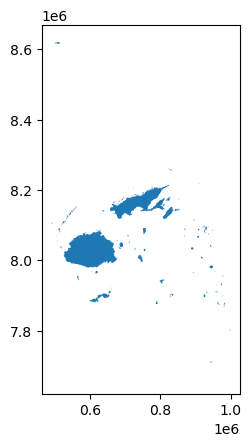

In [87]:
fiji.plot()

Setup ring buffers

In [88]:
buffer_100 = fiji.buffer(-100)
# buffer_250 = fiji.buffer(-250)
# buffer_500 = fiji.buffer(-500)
# buffer_1000 = fiji.buffer(-1000)
# buffer_2000 = fiji.buffer(-2000)
# buffer_3000 = fiji.buffer(-3000)

In [92]:
buffer_100 = buffer_100.to_crs("EPSG:32760")

In [93]:
ring_buffer_100 = buffer_100.symmetric_difference(fiji, align=True)
# ring_buffer_250 = buffer_250.symmetric_difference(fiji, align=True)
# ring_buffer_500 = buffer_500.symmetric_difference(fiji, align=True)
# ring_buffer_1000 = buffer_1000.symmetric_difference(fiji, align=True)
# ring_buffer_2000 = buffer_2000.symmetric_difference(fiji, align=True)
# ring_buffer_3000 = buffer_3000.symmetric_difference(fiji, align=True)

In [94]:
ring_buffer_100.to_file("fiji/ring_buffer_100.geojson")
# ring_buffer_250.to_file("fiji/ring_buffer_250.geojson")
# ring_buffer_500.to_file("fiji/ring_buffer_500.geojson")
# ring_buffer_1000.to_file("fiji/ring_buffer_1000.geojson")
# ring_buffer_2000.to_file("fiji/ring_buffer_2000.geojson")
# ring_buffer_3000.to_file("fiji/ring_buffer_3000.geojson")

In [95]:
polygon = ring_buffer_100.geometry[0]

In [96]:
# Flatten to a single Polygon
flattened_polygon = unary_union(ring_buffer_100.geometry)

In [97]:
polygon = flattened_polygon

In [98]:
buffer_gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:32760")  # Adjust CRS as needed

In [99]:
buffer_gdf.to_file("buffer_gdf.geojson")

In [12]:
# clipped.to_file("clipped_100_fj.geojson")

In [13]:
# Yasa_fj_34kn = gpd.read_file("swaths/Yasa_FJ_34kn.geojson").fillna(0).to_crs("EPSG:32760")

/tmp/ipykernel_1486/3387814996.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Yasa_fj_34kn = gpd.read_file("swaths/Yasa_FJ_34kn.geojson").fillna(0).to_crs("EPSG:4326")


In [101]:
print("Polygon GDF validity:")
print(polygon_gdf.is_valid)

Polygon GDF validity:
0    True
dtype: bool


In [102]:
Yasa_fj_34kn["geometry"] = Yasa_fj_34kn.geometry.buffer(0)

In [103]:
print("Yasa_fj_34kn validity:")
print(Yasa_fj_34kn.is_valid)

Yasa_fj_34kn validity:
0    True
dtype: bool


In [104]:
clipped_Yasa_34kn = gpd.clip(polygon_gdf, Yasa_fj_34kn)

In [112]:
clipped_Yasa_34kn = clipped_Yasa_34kn.to_crs("EPSG:32760")

In [113]:
# clipped_Yasa_34kn.to_file("clipped_Yasa_34kn.geojson")

In [114]:
fiji_gfw = rioxarray.open_rasterio("GFW/Fiji_GFW_2000_2023.tif")

In [115]:
# print("CRS:", clipped_Yasa_34kn.crs)
print("CRS:", fiji_gfw.rio.crs)

CRS: EPSG:4326


In [116]:
# Reproject the raster
fiji_gfw = fiji_gfw.rio.reproject("EPSG:32760")

In [117]:
# Assuming you have a GeoDataFrame for the mask
clipped_34kn_100m_gfw = fiji_gfw.rio.clip(clipped_Yasa_34kn.geometry, fiji_gfw.rio.crs)

In [118]:
# clipped_34kn_100m_gfw.rio.to_raster("clipped_34kn_100m_gfw.tif")

In [119]:
# Get the bounding box of the raster
raster_bounds = clipped_34kn_100m_gfw.rio.bounds()
print("Raster Bounds:", raster_bounds)

Raster Bounds: (489338.6152427596, 7875457.740070929, 820866.3500067786, 8213306.916816804)


In [120]:
raster_extent = box(*raster_bounds)

# Clip the vector data
clipped_gdf = clipped_Yasa_34kn.clip(raster_extent)

# Save the clipped GeoDataFrame (optional)
clipped_gdf.to_file("clipped_yasa_34kn_TCL.geojson")

In [121]:
raster_path = "GFW/LossYear_GFW_Fiji.tif"

In [122]:
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform  # Get the affine transform
    crs = "EPSG:32760"

In [123]:
import rasterio
import numpy as np

# Path to the input raster and the output raster
input_raster_path = "GFW/LossYear_GFW_Fiji.tif"
output_raster_path = "GFW/GFW_TC_Winston_2016.tif"

# The specific value you want to extract (e.g., 100)
specific_value = 15

# Ensure no-data value is valid for uint8
dtype = data.dtype
if dtype == "uint8":
    custom_nodata = 255  # Valid no-data value for uint8
else:
    custom_nodata = -9999  # Default for other data types

# Open the input raster file
with rasterio.open(input_raster_path) as src:
    # Read the data for the first band (you can modify for multi-band raster)
    data = src.read(1)  # Read the first band
    
    # Create a mask where the value matches the specific value
    mask = data == specific_value
    
    # Replace the non-matching values with the custom no-data value
    data[~mask] = custom_nodata  # Set all other pixels to custom no-data value
    
    # Copy the metadata from the source raster
    metadata = src.meta
    
    # Update the metadata to reflect that the new raster is single-band
    metadata.update(count=1, nodata=custom_nodata)
    
    # Create and write the new raster file with the filtered values
    with rasterio.open(output_raster_path, 'w', **metadata) as dst:
        dst.write(data, 1)  # Write the modified data (filtered)

print(f"New raster created: {output_raster_path}")


New raster created: GFW/GFW_TC_Winston_2016.tif


In [124]:
# Path to the raster file
input_raster_path = "GFW/GFW_TC_Winston_2016.tif"
output_raster_path = "GFW/GFW_TC_Winston_2016.tif"

# Define the new CRS (e.g., EPSG:32760 for Web Mercator)
new_crs = "EPSG:32760"

# Open the raster file
with rasterio.open(input_raster_path) as src:
    # Read the metadata
    metadata = src.meta.copy()
    
    # Update the CRS in the metadata
    metadata.update(crs=new_crs)
    
    # Write a new file with the updated CRS
    with rasterio.open(output_raster_path, 'w', **metadata) as dst:
        dst.write(src.read())  # Copy all data bands to the new file

print(f"Raster CRS updated and saved to: {output_raster_path}")

Raster CRS updated and saved to: GFW/GFW_TC_Winston_2016.tif


In [125]:
# Extract shapes and values from the raster
shapes_generator = shapes(data, transform=transform)

# Create a list of geometries and values
geometries = []
for geom, value in shapes_generator:
    geometries.append({"geometry": shape(geom), "value": value})

In [126]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometries).fillna(0)

# Assign a CRS (use the CRS of the raster if available)
gdf.set_crs(polygon_gdf.crs, inplace=True)

# Display the GeoDataFrame
print(gdf.head())

                                            geometry  value
0  POLYGON ((179.08806 -16.48822, 179.08806 -16.4...   15.0
1  POLYGON ((179.06084 -16.49281, 179.06084 -16.4...   15.0
2  POLYGON ((179.14465 -16.49388, 179.14465 -16.4...   15.0
3  POLYGON ((179.09641 -16.50116, 179.09641 -16.5...   15.0
4  POLYGON ((178.91289 -16.50278, 178.91289 -16.5...   15.0


In [127]:
# print("CRS:", clipped_Yasa_34kn.crs)
print("CRS:", polygon_gdf.crs)
print("CRS:", gdf.crs)

CRS: EPSG:4326
CRS: EPSG:4326


In [128]:
print(gdf.head())

                                            geometry  value
0  POLYGON ((179.08806 -16.48822, 179.08806 -16.4...   15.0
1  POLYGON ((179.06084 -16.49281, 179.06084 -16.4...   15.0
2  POLYGON ((179.14465 -16.49388, 179.14465 -16.4...   15.0
3  POLYGON ((179.09641 -16.50116, 179.09641 -16.5...   15.0
4  POLYGON ((178.91289 -16.50278, 178.91289 -16.5...   15.0


In [129]:
# gdf.to_file("gdf_test.geojson")

In [130]:
# clipped_Yasa_34kn = gpd.clip(polygon_gdf, gdf)

In [131]:
# Ensure the GeoDataFrame contains Polygon geometries
# Here, we assume that the first geometry in the GeoDataFrame is a Polygon.
polygons = gdf.geometry.tolist()

# Convert to a MultiPolygon (even if you have only one polygon)
multipolygon = MultiPolygon(polygons)

In [132]:
# If you want to create a new GeoDataFrame with the MultiPolygon:
multipolygon_gdf = gpd.GeoDataFrame({'geometry': [multipolygon]})

# Set the CRS if necessary (optional)
multipolygon_gdf.set_crs(gdf.crs, inplace=True)

# Display the result
print(multipolygon_gdf.head())

                                            geometry
0  MULTIPOLYGON (((179.08806 -16.48822, 179.08806...


In [133]:
print(polygon_gdf.head())

                                            geometry
0  MULTIPOLYGON (((-179.87944 -19.02111, -179.879...


In [134]:
# print("CRS:", clipped_Yasa_34kn.crs)
print("CRS:", polygon_gdf.crs)


CRS: EPSG:4326


In [140]:
print(multipolygon_gdf.crs)

EPSG:4326


In [141]:
# gdf.to_file("gfw_gdf.geojson")

In [145]:
filtered_gdf = filtered_gdf.to_crs("EPSG:32760")

In [142]:
# Specify the column and the specific value to filter
filter_column = "value"  # Column with the values
specific_value = 15    # Replace with the value you want to extract

# Filter the GeoDataFrame for the specific value
filtered_gdf = gdf[gdf[filter_column] == specific_value]

# Save the filtered GeoDataFrame to a new file (optional)
filtered_gdf.to_file("filtered_polygons.gpkg", driver="GPKG")


In [143]:
# clipped_Yasa_34kn = gpd.clip(polygon_gdf, multipolygon_gdf)

In [146]:
clipped_Yasa_34kn = gpd.clip(filtered_gdf, buffer_gdf)

In [60]:
# clipped_Yasa_34kn = gpd.clip(filtered_gdf, clipped_Yasa_34kn)

In [147]:
print(clipped_Yasa_34kn.head())

                                               geometry  value
3646  POLYGON ((635821.428 7899012.176, 635820.553 7...   15.0
3633  POLYGON ((638082.934 7905527.511, 638082.49 79...   15.0
3609  POLYGON ((576825.413 7986008.138, 576768.42 79...   15.0
3632  POLYGON ((655915.508 7906460.304, 655915.758 7...   15.0
3630  POLYGON ((655309.436 7912073.153, 655309.187 7...   15.0


In [100]:
print(filtered_gdf.crs)
print(polygon_gdf.crs)

EPSG:4326
EPSG:4326


In [63]:
filtered_gdf.to_file("filtered_gdf.geojson")
# polygon_gdf.to_file("polygon_gdf.geojson")

In [67]:
clipped_Yasa_34kn.to_file("clipped_Yasa_34kn_gfw.geojson")

In [55]:
intersection_exists = filtered_gdf.geometry.intersects(polygon_gdf.unary_union).any()
print("Do they intersect?", intersection_exists)

/tmp/ipykernel_1486/940385411.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersection_exists = filtered_gdf.geometry.intersects(polygon_gdf.unary_union).any()


Do they intersect? True
